# LSTMSeq2SeqAttn 60d — Ablation B

### 목적: Dropout 제거 (v1 구조) + Rainfall 차분 유지 → Decoder dropout이 성능 하락 원인인지 검증

| 변경 항목 | v1 (원본) | v2 | 이 실험 (B) |
|----------|:---------:|:--:|:---------:|
| Rainfall | 누적 | 차분 | 차분 (v2 유지) |
| Decoder Dropout | 없음 | 0.2 | **없음 (v1 원복)** |
| LayerNorm 순서 | LN→Drop→FC | Drop→LN→FC | **LN→Drop→FC (v1 원복)** |
| EarlyStopping patience | 5 | 10 | 10 |
| Multi-run (N=3) | ✗ | ✓ | ✓ |
| pin_memory | ✗ | ✓ | ✓ |
| 평가 지표 | MAPE only | +SMAPE,macro | +SMAPE,macro |

0. flow 전처리 (IQR, Savgol)
1. weather 전처리 (차분 (v2 유지))
2. flow & weather merge
3~5. sliding window → split → 정규화
6. Model (**없음 (v1 원복)**)
7~8. 학습 (patience=10, N=3) → 평가

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import random, os, copy

N_RUNS = 3
SEEDS = [42, 123, 7]

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    import torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Multi-run: {N_RUNS} runs, seeds={SEEDS}")

Multi-run: 3 runs, seeds=[42, 123, 7]


### Data Split 구조 (4계절 Block Sampling, 60일 x 4)

각 블록(60일)을 시간 순서대로 70 / 15 / 15로 분할 (블록 간 87분 gap으로 data leak 방지)

| 계절 | Train (~42일) | Val (~9일) | Test (~9일) |
|------|--------------|-------------|--------------|
| Winter | 23/12/01 ~ 24/01/11 | 24/01/11 ~ 24/01/20 | 24/01/20 ~ 24/01/29 |
| Spring | 24/03/15 ~ 24/04/25 | 24/04/25 ~ 24/05/04 | 24/05/04 ~ 24/05/13 |
| Summer | 23/07/01 ~ 23/08/11 | 23/08/11 ~ 23/08/20 | 23/08/20 ~ 23/08/29 |
| Fall | 23/09/15 ~ 23/10/26 | 23/10/26 ~ 23/11/04 | 23/11/04 ~ 23/11/13 |

**예측 구조:** 72분 입력 (10 features) -> 15분 예측 (flow value) x 4 rolling = 1시간

**모델:** LSTM Seq2Seq + **Bahdanau Attention** — 전체 Hidden Sequence 활용
- **기존 Cross-Attention 실패 원인:**
  - Query = h₇₂ (고정) → 모든 step이 동일한 가중치(1/72) → Attention 무효
- **Bahdanau Attention 해결:**
  - Query = **Decoder의 현재 step hidden state** (step마다 다름)
  - step 1의 Query ≠ step 15의 Query → step별로 다른 곳을 참조
- **Model B(Autoreg) 실패와의 차이:**
  - Model B: prev_pred 피드백 → error accumulation + Scheduled Sampling 필요
  - **이 모델: step_embed 입력 → error 격리 + Teacher forcing 불필요**

**Loss:** Step-weighted MSE (step 1=1.0 -> step 15=2.0)
**LR Scheduler:** ReduceLROnPlateau (factor=0.5, patience=3)

0. flow, weather 데이터 Load

In [2]:
BASE_DIR = Path.cwd().parent

# Flow raw data 로드 (J배수지, reservoir/10.csv)
flow_file = BASE_DIR / "data" / "rawdata" / "reservoir" / "10.csv"
df_flow = pd.read_csv(
    flow_file,
    header=None,
    usecols=[1, 2],
    names=['time', 'value']
).sort_values('time').reset_index(drop=True)

df_flow['time'] = pd.to_datetime(df_flow['time'], errors='coerce')
df_flow = df_flow.dropna(subset=['time'])
print(f"Flow 원본: {len(df_flow):,}개 ({df_flow['time'].min()} ~ {df_flow['time'].max()})")

# Weather 파일 경로
weather_file = BASE_DIR / "data" / "rawdata" / "weather"

Flow 원본: 943,434개 (2023-01-01 00:01:00 ~ 2024-10-17 17:19:00)


0-1. Flow 전처리
- IQR 이상치 + 음수 + 급변동 제거 → NaN
- Linear interpolation (양방향)
- Savitzky-Golay filter (window=51, polyorder=2)

In [3]:
from scipy.signal import savgol_filter

# 1. IQR 이상치 + 음수 + 급변동 → NaN 처리
Q1 = df_flow['value'].quantile(0.25)
Q3 = df_flow['value'].quantile(0.75)
IQR = Q3 - Q1

iqr_mask = (df_flow['value'] < Q1 - 1.5 * IQR) | (df_flow['value'] > Q3 + 1.5 * IQR)
negative_mask = df_flow['value'] < 0
diff = df_flow['value'].diff().abs()
spike_threshold = diff.quantile(0.999)
spike_mask = diff > spike_threshold

total_mask = iqr_mask | negative_mask | spike_mask
df_flow.loc[total_mask, 'value'] = np.nan

print(f"이상치 제거: IQR={iqr_mask.sum()}, 음수={negative_mask.sum()}, "
      f"급변동(>{spike_threshold:.2f})={spike_mask.sum()}, 총={total_mask.sum()}")

# 2. Linear interpolation (양방향) + clip
df_flow['value'] = df_flow['value'].interpolate(method='linear', limit_direction='both')
df_flow['value'] = df_flow['value'].clip(lower=0)

# 3. Savitzky-Golay filter (노이즈 제거, window=51, polyorder=2)
df_flow['value'] = savgol_filter(df_flow['value'], window_length=51, polyorder=2)
df_flow['value'] = df_flow['value'].clip(lower=0)

print(f"전처리 완료: {len(df_flow):,}개, "
      f"범위 [{df_flow['value'].min():.2f}, {df_flow['value'].max():.2f}]")

이상치 제거: IQR=21, 음수=0, 급변동(>91.06)=944, 총=962
전처리 완료: 943,434개, 범위 [0.00, 325.52]


In [4]:
# 전처리 결과 저장 (원본 보호 + 재현성)
save_path = BASE_DIR / "data" / "processed" / "flow_preprocessed.csv"
df_flow.to_csv(save_path, index=False)
print(f"저장 완료: {save_path} ({len(df_flow):,}행)")

저장 완료: /home/kp/web/work/pro/data/processed/flow_preprocessed.csv (943,434행)


- weather 데이터 인코딩, concat

In [5]:
def read_weather_csv(f):
    for enc in ["euc-kr", "cp949", "utf-8", "utf-8-sig"]:
        try:
            return pd.read_csv(f, encoding=enc)
        except (UnicodeDecodeError, UnicodeError):
            continue
    raise ValueError(f"인코딩 실패: {f.name}")

files = sorted(weather_file.glob("*.csv"))
print(f"읽을 파일 수: {len(files)}")

weather = pd.concat(
    [read_weather_csv(f) for f in files],
    ignore_index=True
)
print(f"concat 후 행 수: {len(weather):,}")

읽을 파일 수: 23
concat 후 행 수: 1,885,020


- 데이터 저장

In [6]:
# weather 전체 concat 결과 저장 (원본 보호)
weather.to_csv(BASE_DIR / "data" / "processed" / "weather_total_raw.csv", index=False, encoding="utf-8-sig")

1. weather 전처리 (★ Rainfall: 차분 변환 — v2 동일)

In [7]:
weather['일시'] = pd.to_datetime(weather['일시'])

# 결측 처리: 강수량 0 채움, 기온/습도 linear 보간 (최대 60분 gap)
weather['0.5mm 일 누적 강수량(mm)'] = weather['0.5mm 일 누적 강수량(mm)'].fillna(0)
weather['기온(℃)'] = weather['기온(℃)'].interpolate(method='linear', limit=60)
weather['상대습도(%)'] = weather['상대습도(%)'].interpolate(method='linear', limit=60)

# ★ [개선 5] Rainfall 차분 변환: 일 누적 → 분당 변화량
# 원본: 0시에 리셋되며 단조 증가하는 누적값 → LSTM이 리셋 패턴 학습 어려움
# 차분: diff()로 변화량 추출 + 음수(리셋 시점)는 0으로 클리핑
rainfall_raw = weather['0.5mm 일 누적 강수량(mm)'].copy()
rainfall_diff = rainfall_raw.diff().fillna(0)
rainfall_diff = rainfall_diff.clip(lower=0)  # 0시 리셋(음수 차분) → 0

print(f"Rainfall 변환: 누적 → 차분")
print(f"  원본 범위: [{rainfall_raw.min():.2f}, {rainfall_raw.max():.2f}]")
print(f"  차분 범위: [{rainfall_diff.min():.4f}, {rainfall_diff.max():.4f}]")
print(f"  비영점 비율: {(rainfall_diff > 0).mean()*100:.1f}%")

weather['0.5mm 일 누적 강수량(mm)'] = rainfall_diff

# 장기 결측(>60분) 행 제거 — LSTM이 가짜 패턴 학습 방지
before = len(weather)
weather = weather.dropna(subset=['기온(℃)', '상대습도(%)'])
print(f'장기 결측 제거: {before:,} -> {len(weather):,} ({len(weather)/before*100:.1f}% 유지)')

weather = weather.rename(columns={
    '일시': 'datetime',
    '기온(℃)': 'temperature',
    '0.5mm 일 누적 강수량(mm)': 'rainfall',
    '상대습도(%)': 'humidity',
})

# 중복 timestamp 제거 (첫 번째 행 유지)
weather = weather.drop_duplicates(subset='datetime', keep='first')
weather = weather.sort_values('datetime').reset_index(drop=True)

# 시간 불연속 경계 표시 — segment 단위 sliding window용
time_diff = weather['datetime'].diff()
seg_boundary = time_diff > pd.Timedelta(minutes=1)
weather['segment_id'] = seg_boundary.cumsum()
print(f'연속 세그먼트 수: {weather["segment_id"].nunique()}')

print(weather.shape)
print(weather.head())

Rainfall 변환: 누적 → 차분
  원본 범위: [0.00, 160.00]
  차분 범위: [0.0000, 119.0000]
  비영점 비율: 0.3%
장기 결측 제거: 1,885,020 -> 1,788,078 (94.9% 유지)
연속 세그먼트 수: 3564
(894039, 5)
             datetime  temperature  rainfall  humidity  segment_id
0 2023-01-01 00:01:00         -3.3       0.0      91.6           0
1 2023-01-01 00:02:00         -3.3       0.0      91.6           0
2 2023-01-01 00:03:00         -3.3       0.0      91.6           0
3 2023-01-01 00:04:00         -3.2       0.0      91.6           0
4 2023-01-01 00:05:00         -3.2       0.0      91.6           0


In [8]:
weather.describe()

,datetime,temperature,rainfall,humidity,segment_id
count,894039,894039.000000,894039.000000,894039.000000,894039.000000
mean,2023-12-09 07:18:45.749011,15.358957,0.002827,71.807508,1596.019969
min,2023-01-01 00:01:00,-16.500000,0.000000,2.900000,0.000000
25%,2023-07-03 09:58:30,6.300000,0.000000,57.200000,465.000000
50%,2023-12-13 20:09:00,16.500000,0.000000,76.000000,1066.000000
75%,2024-05-25 11:14:30,24.700000,0.000000,90.300000,3267.000000
max,2024-11-01 00:00:00,37.700000,119.000000,99.900000,3563.000000
std,NaN,10.908432,0.158143,21.188111,1320.075920


In [9]:
df = pd.DataFrame(weather)
df.isnull().sum()

datetime       0
temperature    0
rainfall       0
humidity       0
segment_id     0
dtype: int64

- rainfall: ★ 분당 변화량 (차분 변환) — v2 동일

In [10]:
df_weather = df[['datetime', 'temperature', 'rainfall', 'humidity', 'segment_id']].copy()

2-1. weather data merge
2-2. weather, time feature 추가

In [11]:
df_merged = pd.merge(df_flow, df_weather, how='inner', left_on='time', right_on="datetime")

In [12]:
df_merged = df_merged.drop(columns=['datetime'])

# 1분 단위 유지 (리샘플링 없음)
df_merged = df_merged.sort_values('time').reset_index(drop=True)
df_merged = df_merged.dropna()
print(f"데이터: {len(df_merged):,}개 (1분 단위)")

# ★ merge 후 시간 불연속 경계 재계산 (weather segment_id 대체)
# weather의 segment_id는 weather 단독 기준이므로,
# flow+weather inner merge 후 실제 불연속을 반영해야 정확함
time_diff_merged = df_merged['time'].diff()
seg_boundary_merged = time_diff_merged > pd.Timedelta(minutes=1)
df_merged['segment_id'] = seg_boundary_merged.cumsum()
print(f"merge 후 연속 세그먼트 수: {df_merged['segment_id'].nunique()}")

# Cyclical temporal features
t: pd.Series = df_merged['time']

# int -> float cast for arithmetic with np.pi
hour = t.dt.hour.astype(np.float64)
minute = t.dt.minute.astype(np.float64)
dow = t.dt.dayofweek.astype(np.float64)
doy = t.dt.dayofyear.astype(np.float64)

# 시간정보 (분 단위 하루 주기, T=1440)
minute_of_day = hour * 60 + minute
df_merged['time_sin'] = 0.5 * np.sin(2 * np.pi * minute_of_day / 1440) + 0.5
df_merged['time_cos'] = 0.5 * np.cos(2 * np.pi * minute_of_day / 1440) + 0.5

# 요일 (주간 주기, T=7)
df_merged['dow_sin'] = 0.5 * np.sin(2 * np.pi * dow / 7) + 0.5
df_merged['dow_cos'] = 0.5 * np.cos(2 * np.pi * dow / 7) + 0.5

# 계절 (연간 주기, T=365.25)
df_merged['season_sin'] = 0.5 * np.sin(2 * np.pi * doy / 365.25) + 0.5
df_merged['season_cos'] = 0.5 * np.cos(2 * np.pi * doy / 365.25) + 0.5

print(f"Temporal features 추가 완료: {df_merged.shape}")
print(df_merged.head())

데이터: 872,723개 (1분 단위)
merge 후 연속 세그먼트 수: 4158
Temporal features 추가 완료: (872723, 12)
                 time      value  temperature  rainfall  humidity  segment_id  \
0 2023-01-01 00:01:00  96.577302         -3.3       0.0      91.6           0   
1 2023-01-01 00:02:00  96.739744         -3.3       0.0      91.6           0   
2 2023-01-01 00:03:00  96.895855         -3.3       0.0      91.6           0   
3 2023-01-01 00:04:00  97.045636         -3.2       0.0      91.6           0   
4 2023-01-01 00:05:00  97.189086         -3.2       0.0      91.6           0   

   time_sin  time_cos   dow_sin   dow_cos  season_sin  season_cos  
0  0.502182  0.999995  0.109084  0.811745    0.508601    0.999926  
1  0.504363  0.999981  0.109084  0.811745    0.508601    0.999926  
2  0.506545  0.999957  0.109084  0.811745    0.508601    0.999926  
3  0.508726  0.999924  0.109084  0.811745    0.508601    0.999926  
4  0.510907  0.999881  0.109084  0.811745    0.508601    0.999926  


In [13]:
df_merged.shape, df_merged.info()

<class 'pandas.DataFrame'>
RangeIndex: 872723 entries, 0 to 872722
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         872723 non-null  datetime64[us]
 1   value        872723 non-null  float64       
 2   temperature  872723 non-null  float64       
 3   rainfall     872723 non-null  float64       
 4   humidity     872723 non-null  float64       
 5   segment_id   872723 non-null  int64         
 6   time_sin     872723 non-null  float64       
 7   time_cos     872723 non-null  float64       
 8   dow_sin      872723 non-null  float64       
 9   dow_cos      872723 non-null  float64       
 10  season_sin   872723 non-null  float64       
 11  season_cos   872723 non-null  float64       
dtypes: datetime64[us](1), float64(10), int64(1)
memory usage: 79.9 MB


((872723, 12), None)

In [14]:
df_merged.describe()

,time,value,temperature,rainfall,humidity,segment_id,time_sin,time_cos,dow_sin,dow_cos,season_sin,season_cos
count,872723,872723.000000,872723.000000,872723.000000,872723.000000,872723.000000,872723.000000,872723.000000,872723.000000,872723.000000,8.727230e+05,872723.000000
mean,2023-12-01 18:39:20.141650,151.786570,15.354982,0.002846,71.595445,1853.432576,0.500568,0.498633,0.496760,0.498728,5.197144e-01,0.470201
min,2023-01-01 00:01:00,0.000000,-16.500000,0.000000,2.900000,0.000000,0.000000,0.000000,0.012536,0.049516,2.889877e-07,0.000010
25%,2023-06-27 11:00:30,109.030874,6.100000,0.000000,56.900000,613.000000,0.146447,0.144907,0.109084,0.049516,1.605898e-01,0.128500
50%,2023-12-06 15:46:00,144.881767,16.500000,0.000000,75.700000,1311.000000,0.502182,0.497818,0.500000,0.388740,5.600631e-01,0.457583
75%,2024-05-14 15:26:30,192.717293,24.800000,0.000000,90.000000,3509.000000,0.853553,0.852007,0.890916,0.811745,8.732941e-01,0.812944
max,2024-10-17 17:19:00,325.516638,37.700000,119.000000,99.900000,4157.000000,1.000000,0.999995,0.987464,1.000000,9.999928e-01,0.999926
std,NaN,56.898401,11.013743,0.159978,21.235732,1468.650283,0.353499,0.353606,0.352849,0.354239,3.565895e-01,0.348665


In [15]:
# 2-3. 계절별 Block Sampling (60일 × 4계절, 2023-2024 교차)
# 45일 대비 데이터 확대 효과 검증 (단일 변인: 기간만 변경)

season_ranges = [
    ('2023-12-01', '2024-01-29', 'Winter'),
    ('2024-03-15', '2024-05-13', 'Spring'),
    ('2023-07-01', '2023-08-29', 'Summer'),
    ('2023-09-15', '2023-11-13', 'Fall'),
]

blocks = []
for i, (start, end, name) in enumerate(season_ranges):
    mask = (df_merged['time'] >= start) & (df_merged['time'] <= end)
    block = df_merged[mask].copy()
    block['block_id'] = i
    blocks.append(block)
    print(f"[{name}] {start} ~ {end}: {len(block):,} rows")

df_merged = pd.concat(blocks, ignore_index=True)
print(f"\nTotal: {len(df_merged):,} rows (4-season block sampling, 60일 × 4)")

[Winter] 2023-12-01 ~ 2024-01-29: 80,828 rows
[Spring] 2024-03-15 ~ 2024-05-13: 78,794 rows
[Summer] 2023-07-01 ~ 2023-08-29: 83,256 rows
[Fall] 2023-09-15 ~ 2023-11-13: 80,430 rows

Total: 323,308 rows (4-season block sampling, 60일 × 4)


3. Sliding Windows 생성
- X: (n_samples, input_time, 10) — value, temperature, rainfall, humidity + 6 cyclical features
- y: (n_samples, output_time) — value만 예측

In [16]:
feature_cols = ['value', 'temperature', 'rainfall', 'humidity',
                'time_sin', 'time_cos', 'dow_sin', 'dow_cos',
                'season_sin', 'season_cos']
scale_cols = ['value', 'temperature', 'rainfall', 'humidity']  # MinMaxScaler target (sin/cos excluded)
target_col = 'value'
input_time = 72    # 72 steps × 1min = 72min
output_time = 15   # 15 steps × 1min = 15min (× 4 rolling = 1h)

print(f"=== Settings ===")
print(f"Input: {input_time} steps ({input_time}min = {input_time/60:.1f}h), {len(feature_cols)} features")
print(f"Output: {output_time} steps ({output_time}min) × 4 rolling = {output_time*4}min")


=== Settings ===
Input: 72 steps (72min = 1.2h), 10 features
Output: 15 steps (15min) × 4 rolling = 60min


4. Train / Val / Test Split (0.7 / 0.15 / 0.15)
- Split 경계에 gap 적용 → sliding window 겹침(data leak) 방지

In [17]:
# Sliding window 생성 + Train/Val/Test split (block × segment 독립)
# ★ 수정: segment_id 경계를 넘는 window 생성 방지
# split 경계에 gap 적용 → sliding window 겹침(data leak) 방지

train_ratio, val_ratio = 0.7, 0.15
split_gap = input_time + output_time  # 87 steps gap (data leak 방지)
min_segment_len = input_time + output_time  # 세그먼트 최소 길이

X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []
test_times_list = []

skipped_segments = 0
used_segments = 0

for block_id in sorted(df_merged['block_id'].unique()):
    block = df_merged[df_merged['block_id'] == block_id]
    
    # ★ block 내 segment별로 sliding window 생성
    seg_X, seg_y, seg_times = [], [], []
    
    for seg_id in sorted(block['segment_id'].unique()):
        segment = block[block['segment_id'] == seg_id].reset_index(drop=True)
        
        if len(segment) < min_segment_len:
            skipped_segments += 1
            continue  # 너무 짧은 세그먼트 스킵
        
        used_segments += 1
        seg_features = segment[feature_cols].values.astype(np.float32)
        seg_target = segment[target_col].values.astype(np.float32)
        seg_time = segment['time'].values
        
        n_samples = len(segment) - input_time - output_time + 1
        for i in range(n_samples):
            seg_X.append(seg_features[i : i + input_time])
            seg_y.append(seg_target[i + input_time : i + input_time + output_time])
            seg_times.append(seg_time[i + input_time])
    
    if len(seg_X) == 0:
        print(f"Block {block_id}: 유효 윈도우 없음 (스킵)")
        continue
    
    X_block = np.array(seg_X)
    y_block = np.array(seg_y)
    times_block = np.array(seg_times)
    n_samples = len(X_block)

    # gap을 두어 Train/Val/Test 간 window 겹침 방지
    t_end = int(n_samples * train_ratio)
    v_start = t_end + split_gap
    v_end = v_start + int(n_samples * val_ratio)
    test_start = v_end + split_gap

    X_train_list.append(X_block[:t_end])
    y_train_list.append(y_block[:t_end])
    X_val_list.append(X_block[v_start:v_end])
    y_val_list.append(y_block[v_start:v_end])
    X_test_list.append(X_block[test_start:])
    y_test_list.append(y_block[test_start:])

    for i in range(test_start, n_samples):
        test_times_list.append(times_block[i])

    n_train = t_end
    n_val = v_end - v_start
    n_test = n_samples - test_start
    print(f"Block {block_id}: {n_samples:,} samples "
          f"(train={n_train:,} / val={n_val:,} / test={n_test:,}) "
          f"gap={split_gap}")

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)
X_test = np.concatenate(X_test_list)
y_test = np.concatenate(y_test_list)
test_times = np.array(test_times_list)

n_total = len(X_train) + len(X_val) + len(X_test)
print(f"\n=== Sliding Window + Split (Seasonal Blocks × Segments, gap={split_gap}) ===")
print(f"★ Segment-aware: {used_segments}개 세그먼트 사용, {skipped_segments}개 스킵 (< {min_segment_len} steps)")
print(f"X shape: ({input_time}, {len(feature_cols)}), y shape: ({output_time},)")
print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,} | Total: {n_total:,}")
print(f"Memory: X_train {X_train.nbytes/1e6:.1f} MB, y_train {y_train.nbytes/1e6:.1f} MB")

Block 0: 41,514 samples (train=29,059 / val=6,227 / test=6,054) gap=87
Block 1: 55,304 samples (train=38,712 / val=8,295 / test=8,123) gap=87
Block 2: 76,315 samples (train=53,420 / val=11,447 / test=11,274) gap=87
Block 3: 67,289 samples (train=47,102 / val=10,093 / test=9,920) gap=87

=== Sliding Window + Split (Seasonal Blocks × Segments, gap=87) ===
★ Segment-aware: 603개 세그먼트 사용, 1557개 스킵 (< 87 steps)
X shape: (72, 10), y shape: (15,)
Train: 168,293 | Val: 36,062 | Test: 35,371 | Total: 239,726
Memory: X_train 484.7 MB, y_train 10.1 MB


5. 정규화 (Train 기준)
- X: feature별 개별 MinMaxScaler (value, temperature, rainfall, humidity)
- y: value scaler로 정규화

In [18]:
from sklearn.preprocessing import MinMaxScaler

n_features = len(feature_cols)

# Train 데이터로만 scaler fit (scale_cols만)
scalers = {}
for col in scale_cols:
    i = feature_cols.index(col)
    scaler = MinMaxScaler()
    scaler.fit(X_train[:, :, i].reshape(-1, 1))
    scalers[col] = scaler

# X 정규화 (scale_cols만, sin/cos 제외)
def normalize_X(arr):
    arr = arr.copy()
    for col in scale_cols:
        i = feature_cols.index(col)
        s = scalers[col]
        d_min, d_max = np.float32(s.data_min_[0]), np.float32(s.data_max_[0])
        arr[:, :, i] = (arr[:, :, i] - d_min) / (d_max - d_min)
    return arr

X_train_scaled = normalize_X(X_train)
X_val_scaled = normalize_X(X_val)
X_test_scaled = normalize_X(X_test)

# y 정규화 (value scaler 사용)
val_min = np.float32(scalers['value'].data_min_[0])
val_max = np.float32(scalers['value'].data_max_[0])

def normalize_y(arr):
    return (arr - val_min) / (val_max - val_min)

def denormalize_y(arr):
    return arr * (val_max - val_min) + val_min

y_train_scaled = normalize_y(y_train)
y_val_scaled = normalize_y(y_val)
y_test_scaled = normalize_y(y_test)

print(f"Train 기준 Scaler 범위 (scale_cols만):")
for col in scale_cols:
    s = scalers[col]
    print(f"  {col:>12s}: [{s.data_min_[0]:.2f}, {s.data_max_[0]:.2f}]")
print(f"\nsin/cos features ({n_features - len(scale_cols)}개): 정규화 없이 원본 유지 [0, 1]")

Train 기준 Scaler 범위 (scale_cols만):
         value: [0.00, 310.26]
   temperature: [-11.70, 37.70]
      rainfall: [0.00, 54.00]
      humidity: [4.80, 99.90]

sin/cos features (6개): 정규화 없이 원본 유지 [0, 1]


- Tensor 변환 & DataLoader (pin_memory)

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 256
use_pin = (device.type == 'cuda')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          drop_last=True, pin_memory=use_pin, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False,
                        pin_memory=use_pin, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False,
                         pin_memory=use_pin, num_workers=0)

print(f"Train: {len(train_loader)} batches | Val: {len(val_loader)} | Test: {len(test_loader)}")

Device: cuda
Train: 657 batches | Val: 71 | Test: 70


## 6. Model (B: dropout=**없음 (v1 원복)**, LN순서=**LN→Drop→FC (v1 원복)**)

In [ ]:
import torch.nn as nn

class LSTMSeq2SeqAttnModel(nn.Module):
    """v1 구조 복원: Decoder dropout 제거, LN→FC 순서"""
    def __init__(self, input_size=10, hidden_size=128, num_layers=2,
                 output_size=15, embed_dim=16, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.encoder = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.step_embedding = nn.Embedding(output_size, embed_dim)

        self.attn_Wh = nn.Linear(hidden_size, hidden_size, bias=False)
        self.attn_Ws = nn.Linear(hidden_size, hidden_size, bias=False)
        self.attn_V = nn.Linear(hidden_size, 1, bias=False)

        self.decoder = nn.LSTMCell(
            input_size=hidden_size + embed_dim, hidden_size=hidden_size
        )
        # Decoder 전용 dropout 제거: LayerNorm → FC
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc_out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        enc_outputs, (h_n, c_n) = self.encoder(x)
        enc_keys_projected = self.attn_Ws(enc_outputs)

        h_dec = h_n[-1]
        c_dec = c_n[-1]

        predictions = []
        self.attn_weights_all = []
        step_ids = torch.arange(self.output_size, device=x.device)
        step_embs = self.step_embedding(step_ids)

        for t in range(self.output_size):
            query = self.attn_Wh(h_dec).unsqueeze(1)
            energy = torch.tanh(query + enc_keys_projected)
            score = self.attn_V(energy).squeeze(-1)
            attn_weights = torch.softmax(score, dim=1)
            context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)
            self.attn_weights_all.append(attn_weights.detach())

            step_emb = step_embs[t].unsqueeze(0).expand(batch_size, -1)
            dec_input = torch.cat([context, step_emb], dim=1)
            h_dec, c_dec = self.decoder(dec_input, (h_dec, c_dec))

            # Decoder dropout 제거: LayerNorm → FC
            pred_t = self.fc_out(self.layer_norm(h_dec))
            predictions.append(pred_t)

        predictions = torch.cat(predictions, dim=1)
        self.attn_weights_all = torch.stack(self.attn_weights_all, dim=1)
        return predictions

In [21]:
model_name = "Ablation_B"
model_check = LSTMSeq2SeqAttnModel(
    input_size=n_features, hidden_size=128, num_layers=2,
    output_size=output_time, embed_dim=16, dropout=0.2,
)
total_p = sum(p.numel() for p in model_check.parameters())
print(f"Parameters: {total_p:,}")
del model_check

Parameters: 377,585


7. Early Stopping

In [22]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-5, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss: float | None = None
        self.early_stop = False
        self.best_model: dict[str, torch.Tensor] | None = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)

        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f}). Saving model...')
        self.best_model = model.state_dict().copy()

## 8. 학습 (Multi-Run, patience=10)

In [23]:
import torch.optim as optim
import time

num_epochs = 100
learning_rate = 0.001
es_patience = 10

step_weights = torch.linspace(1.0, 2.0, output_time).to(device)

def weighted_mse_loss(pred, target):
    return (step_weights * (pred - target) ** 2).mean()

criterion = weighted_mse_loss

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calc_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calc_smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom > 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100

all_run_results = []
all_run_models = []
all_run_losses = []

for run_idx, seed in enumerate(SEEDS[:N_RUNS]):
    set_seed(seed)
    print(f"\n{'='*60}")
    print(f"Run {run_idx+1}/{N_RUNS} (seed={seed})")
    print(f"{'='*60}")
    
    model = LSTMSeq2SeqAttnModel(
        input_size=n_features, hidden_size=128, num_layers=2,
        output_size=output_time, embed_dim=16, dropout=0.2,
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    early_stopping = EarlyStopping(patience=es_patience, verbose=False)
    
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss_epoch = 0.0
        for batch_X, targets in train_loader:
            batch_X, targets = batch_X.to(device), targets.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss_epoch += loss.item()
        
        avg_train_loss = train_loss_epoch / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss_epoch = 0.0
        with torch.no_grad():
            for batch_X, targets in val_loader:
                batch_X, targets = batch_X.to(device), targets.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, targets)
                val_loss_epoch += loss.item()
        
        avg_val_loss = val_loss_epoch / len(val_loader)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        if (epoch + 1) % 10 == 0:
            print(f'  Epoch [{epoch+1:3d}/{num_epochs}] '
                  f'Train: {avg_train_loss:.6f} '
                  f'Val: {avg_val_loss:.6f} '
                  f'LR: {current_lr:.6f}')
        
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f"  Early Stopping at Epoch {epoch+1} "
                  f"(Best Val Loss: {early_stopping.best_loss:.6f})")
            break
    
    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)
    
    all_run_models.append(copy.deepcopy(model.state_dict()))
    all_run_losses.append({'train': train_losses, 'val': val_losses})
    
    model.eval()
    test_preds_list, test_actuals_list = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            test_preds_list.append(outputs.cpu().numpy())
            test_actuals_list.append(batch_y.numpy())
    
    run_preds = denormalize_y(np.vstack(test_preds_list))
    run_actuals = denormalize_y(np.vstack(test_actuals_list))
    
    run_result = {
        'seed': seed,
        'epoch': len(train_losses),
        'mape': calc_mape(run_actuals.flatten(), run_preds.flatten()),
        'smape': calc_smape(run_actuals.flatten(), run_preds.flatten()),
        'rmse': np.sqrt(mean_squared_error(run_actuals, run_preds)),
        'mae': mean_absolute_error(run_actuals, run_preds),
        'r2': r2_score(run_actuals.flatten(), run_preds.flatten()),
        'bias': float(np.mean(run_actuals - run_preds)),
        'predictions': run_preds,
        'actuals': run_actuals,
    }
    
    step_mapes = []
    for s in range(output_time):
        step_mapes.append(calc_mape(run_actuals[:, s], run_preds[:, s]))
    run_result['step_mapes'] = step_mapes
    
    season_mapes = []
    offset = 0
    for size in [len(arr) for arr in X_test_list]:
        block_a = run_actuals[offset:offset+size]
        block_p = run_preds[offset:offset+size]
        season_mapes.append(calc_mape(block_a.flatten(), block_p.flatten()))
        offset += size
    run_result['season_mapes'] = season_mapes
    run_result['macro_mape'] = np.mean(season_mapes)
    
    all_run_results.append(run_result)
    
    print(f"  → MAPE: {run_result['mape']:.2f}% | SMAPE: {run_result['smape']:.2f}% "
          f"| R²: {run_result['r2']:.4f} | Bias: {run_result['bias']:+.2f} "
          f"| Epoch: {run_result['epoch']}")

print(f"\n{'='*60}")
print("All runs completed")
print(f"{'='*60}")


Run 1/3 (seed=42)
  Epoch [ 10/100] Train: 0.001550 Val: 0.001240 LR: 0.001000
  Epoch [ 20/100] Train: 0.001275 Val: 0.001011 LR: 0.001000
  Epoch [ 30/100] Train: 0.001112 Val: 0.000881 LR: 0.000500
  Epoch [ 40/100] Train: 0.001009 Val: 0.000828 LR: 0.000250
  Epoch [ 50/100] Train: 0.000967 Val: 0.000850 LR: 0.000125
  Epoch [ 60/100] Train: 0.000930 Val: 0.000769 LR: 0.000063
  Early Stopping at Epoch 62 (Best Val Loss: 0.000766)
  → MAPE: 2.69% | SMAPE: 2.69% | R²: 0.9863 | Bias: +0.38 | Epoch: 62

Run 2/3 (seed=123)
  Epoch [ 10/100] Train: 0.001715 Val: 0.001325 LR: 0.001000
  Epoch [ 20/100] Train: 0.001359 Val: 0.001047 LR: 0.000500
  Epoch [ 30/100] Train: 0.001289 Val: 0.001055 LR: 0.000500
  Early Stopping at Epoch 39 (Best Val Loss: 0.001002)
  → MAPE: 3.32% | SMAPE: 3.32% | R²: 0.9830 | Bias: +0.47 | Epoch: 39

Run 3/3 (seed=7)
  Epoch [ 10/100] Train: 0.001550 Val: 0.001205 LR: 0.001000
  Epoch [ 20/100] Train: 0.001181 Val: 0.000993 LR: 0.000500
  Epoch [ 30/100] Trai

### B 결과 요약

In [32]:
metric_labels = {
    'mape': 'MAPE (%)', 'smape': 'SMAPE (%)', 'rmse': 'RMSE',
    'mae': 'MAE', 'r2': 'R²', 'bias': 'Bias', 'macro_mape': 'Macro MAPE (%)'
}

print("=" * 70)
print(f"Multi-Run Summary ({N_RUNS} runs)")
print("=" * 70)

metrics = ['mape', 'smape', 'rmse', 'mae', 'r2', 'bias', 'macro_mape']
print(f"\n{'Metric':<16s}  {'Mean':>8s}  {'Std':>8s}  {'Min':>8s}  {'Max':>8s}")
print("-" * 55)
for m in metrics:
    vals = [r[m] for r in all_run_results]
    print(f"{metric_labels[m]:<16s}  {np.mean(vals):8.4f}  {np.std(vals):8.4f}  "
          f"{np.min(vals):8.4f}  {np.max(vals):8.4f}")

print(f"\n각 Run 상세:")
for r in all_run_results:
    print(f"  seed={r['seed']:3d}: MAPE={r['mape']:.2f}% SMAPE={r['smape']:.2f}% "
          f"R²={r['r2']:.4f} Bias={r['bias']:+.2f} Epoch={r['epoch']}")

print(f"\nStep별 MAPE (mean ± std):")
for s in range(output_time):
    vals = [r['step_mapes'][s] for r in all_run_results]
    print(f"  Step {s+1:2d}: {np.mean(vals):.2f}% ± {np.std(vals):.2f}%")

season_names_list = ['Winter', 'Spring', 'Summer', 'Fall']
print(f"\n계절별 MAPE (mean ± std):")
for i, name in enumerate(season_names_list):
    vals = [r['season_mapes'][i] for r in all_run_results]
    print(f"  {name:8s}: {np.mean(vals):.2f}% ± {np.std(vals):.2f}%")

best_idx = np.argmin([r['mape'] for r in all_run_results])
best_run = all_run_results[best_idx]
print(f"\n★ Best Run: seed={best_run['seed']} (MAPE={best_run['mape']:.2f}%)")

Multi-Run Summary (3 runs)

Metric                Mean       Std       Min       Max
-------------------------------------------------------
MAPE (%)            2.8894    0.3072    2.6588    3.3235
SMAPE (%)           2.8923    0.3057    2.6584    3.3242
RMSE                6.8338    0.3812    6.5128    7.3694
MAE                 4.3435    0.3760    4.0644    4.8749
R²                  0.9854    0.0017    0.9830    0.9868
Bias                0.2779    0.2101   -0.0151    0.4672
Macro MAPE (%)      2.8662    0.2925    2.6290    3.2783

각 Run 상세:
  seed= 42: MAPE=2.69% SMAPE=2.69% R²=0.9863 Bias=+0.38 Epoch=62
  seed=123: MAPE=3.32% SMAPE=3.32% R²=0.9830 Bias=+0.47 Epoch=39
  seed=  7: MAPE=2.66% SMAPE=2.66% R²=0.9868 Bias=-0.02 Epoch=73

Step별 MAPE (mean ± std):
  Step  1: 1.13% ± 0.20%
  Step  2: 1.03% ± 0.07%
  Step  3: 1.21% ± 0.05%
  Step  4: 1.41% ± 0.11%
  Step  5: 1.68% ± 0.17%
  Step  6: 1.99% ± 0.20%
  Step  7: 2.32% ± 0.24%
  Step  8: 2.69% ± 0.30%
  Step  9: 3.06% ± 0.35%
  S

### Best Run 시각화 및 분석

In [33]:
# Best run 기준 변수 준비 (multi-run → single-run 변환)
train_losses = all_run_losses[best_idx]['train']
val_losses = all_run_losses[best_idx]['val']
test_actual_original = best_run['actuals']
test_pred_original = best_run['predictions']

# Best run 모델 로드
model.load_state_dict(all_run_models[best_idx])
model.eval()
print(f"Best run (seed={best_run['seed']}) 변수 준비 완료")

Best run (seed=7) 변수 준비 완료


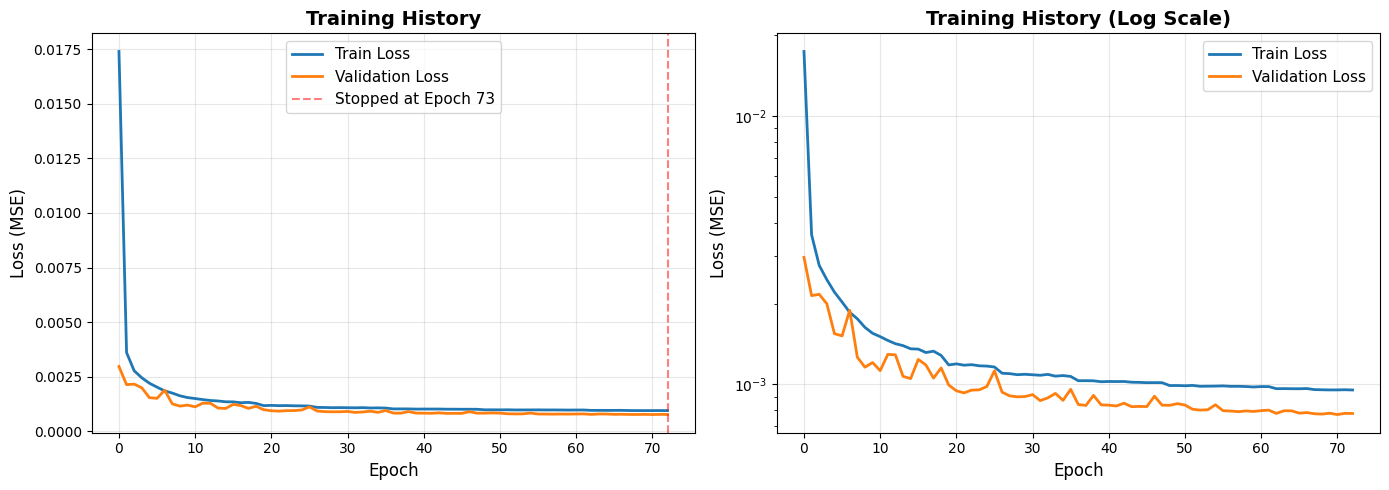

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.axvline(len(train_losses)-1, color='red', linestyle='--', alpha=0.5,
           label=f'Stopped at Epoch {len(train_losses)}')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

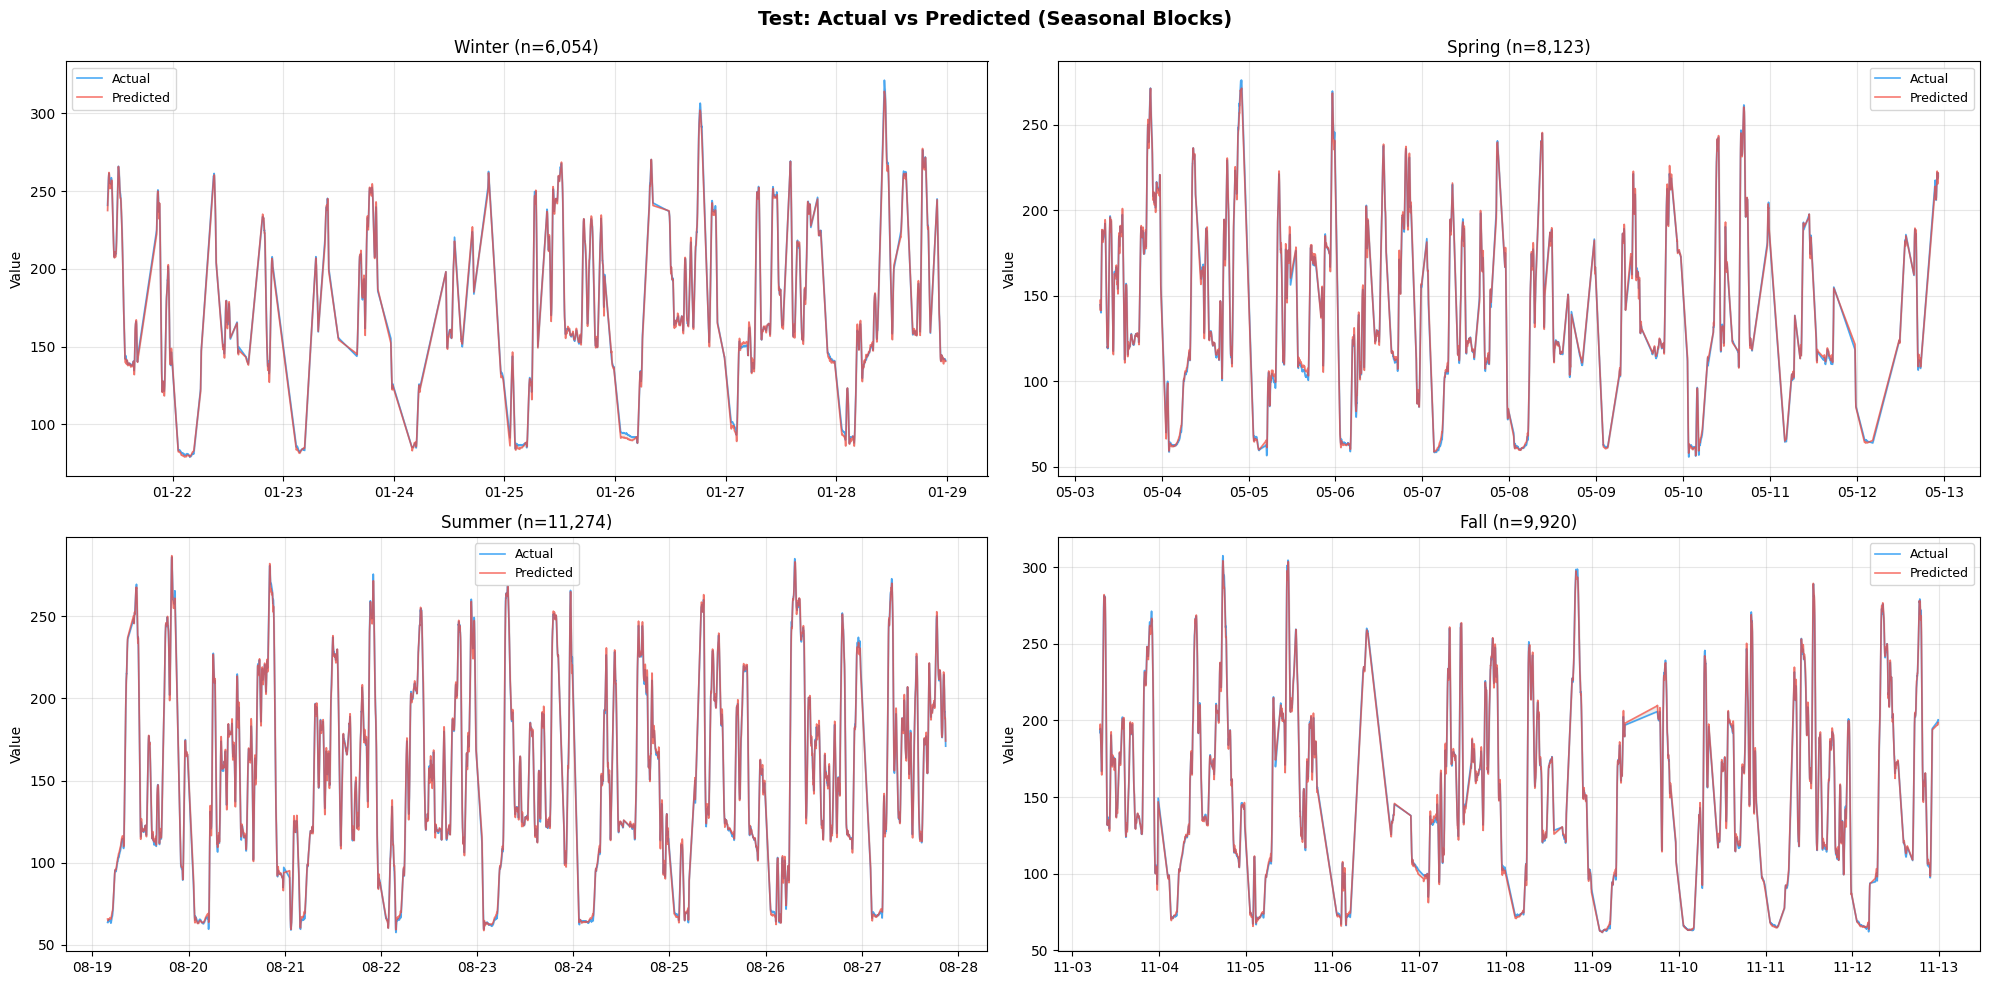

In [35]:
import matplotlib.dates as mdates

actual_series = test_actual_original[:, 0]
pred_series = test_pred_original[:, 0]
plot_times = pd.to_datetime(test_times[:len(actual_series)])

# 2x2 subplot: one per seasonal block
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Test: Actual vs Predicted (Seasonal Blocks)', fontsize=14, fontweight='bold')

season_names = ['Winter', 'Spring', 'Summer', 'Fall']
block_sizes = [len(arr) for arr in X_test_list]
offset = 0

for ax, name, size in zip(axes.flat, season_names, block_sizes):
    t = plot_times[offset:offset+size]
    a = actual_series[offset:offset+size]
    p = pred_series[offset:offset+size]

    ax.plot(t, a, label='Actual', linewidth=1.2, color='#2196F3', alpha=0.8)
    ax.plot(t, p, label='Predicted', linewidth=1.2, color='#F44336', alpha=0.7)
    ax.fill_between(t, a, p, alpha=0.15, color='gray')
    ax.set_title(f'{name} (n={size:,})', fontsize=12)
    ax.set_ylabel('Value')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    offset += size

plt.tight_layout()
plt.show()

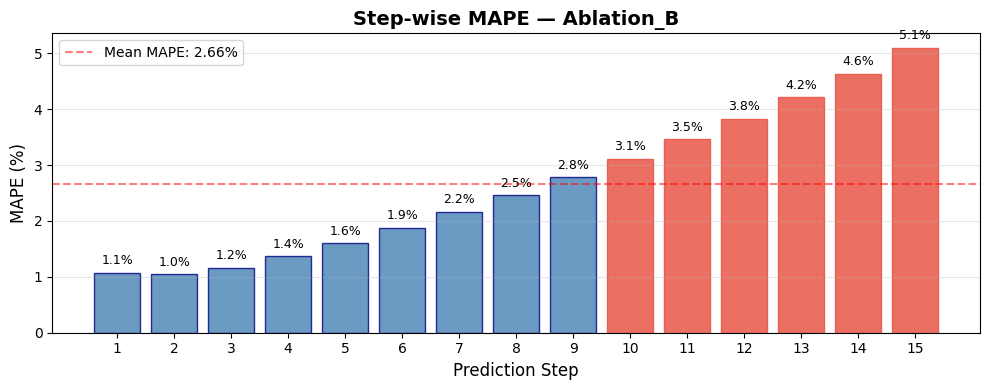


Step-wise MAPE:
  Step  1: 1.07%
  Step  2: 1.05%
  Step  3: 1.17%
  Step  4: 1.36%
  Step  5: 1.60%
  Step  6: 1.87%
  Step  7: 2.17%
  Step  8: 2.46%
  Step  9: 2.78%
  Step 10: 3.11%
  Step 11: 3.46%
  Step 12: 3.82%
  Step 13: 4.21%
  Step 14: 4.63%
  Step 15: 5.10% ← worst
  Mean:   2.66%


In [36]:
# Step별 MAPE 분석 — 후반 step 성능 저하 확인
step_mapes = []
for s in range(output_time):
    actual_s = test_actual_original[:, s]
    pred_s = test_pred_original[:, s]
    mask = actual_s != 0
    mape_s = np.mean(np.abs((actual_s[mask] - pred_s[mask]) / actual_s[mask])) * 100
    step_mapes.append(mape_s)

plt.figure(figsize=(10, 4))
bars = plt.bar(range(1, output_time + 1), step_mapes, color='steelblue', edgecolor='navy', alpha=0.8)

# 색상 강조: MAPE가 높은 step
for i, (bar, mape) in enumerate(zip(bars, step_mapes)):
    if mape > np.mean(step_mapes) * 1.1:  # 평균 대비 10% 이상이면 빨간색
        bar.set_color('#e74c3c')
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)

plt.axhline(y=np.mean(step_mapes), color='red', linestyle='--', alpha=0.5, label=f'Mean MAPE: {np.mean(step_mapes):.2f}%')
plt.xlabel('Prediction Step', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.title(f'Step-wise MAPE — {model_name}', fontsize=14, fontweight='bold')
plt.xticks(range(1, output_time + 1))
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nStep-wise MAPE:")
for s, mape in enumerate(step_mapes):
    flag = " ← worst" if mape == max(step_mapes) else ""
    print(f"  Step {s+1:2d}: {mape:.2f}%{flag}")
print(f"  Mean:   {np.mean(step_mapes):.2f}%")

Step별 예측 감소 추세 — 선형 회귀 기울기 (step당 변화량)

                    MAPE          RMSE           MAE            R2          Bias
----------------------------------------------------------------------
       All  +0.298%/step  +0.715/step  +0.484/step  -0.00278/step  +0.058/step
    Winter  +0.311%/step  +0.750/step  +0.537/step  -0.00330/step  +0.203/step
    Spring  +0.263%/step  +0.643/step  +0.412/step  -0.00266/step  +0.046/step
    Summer  +0.310%/step  +0.714/step  +0.488/step  -0.00283/step  +0.012/step
      Fall  +0.305%/step  +0.749/step  +0.507/step  -0.00279/step  +0.030/step

             Step 1 MAPE   Step 15 MAPE     Ratio   Step 1 R2   Step 15 R2
----------------------------------------------------------------------
       All        1.07%         5.10%      4.8x      0.9988       0.9579
    Winter        0.99%         5.14%      5.2x      0.9987       0.9495
    Spring        1.18%         4.70%      4.0x      0.9987       0.9600
    Summer        1.11%         5.32%      4.8x

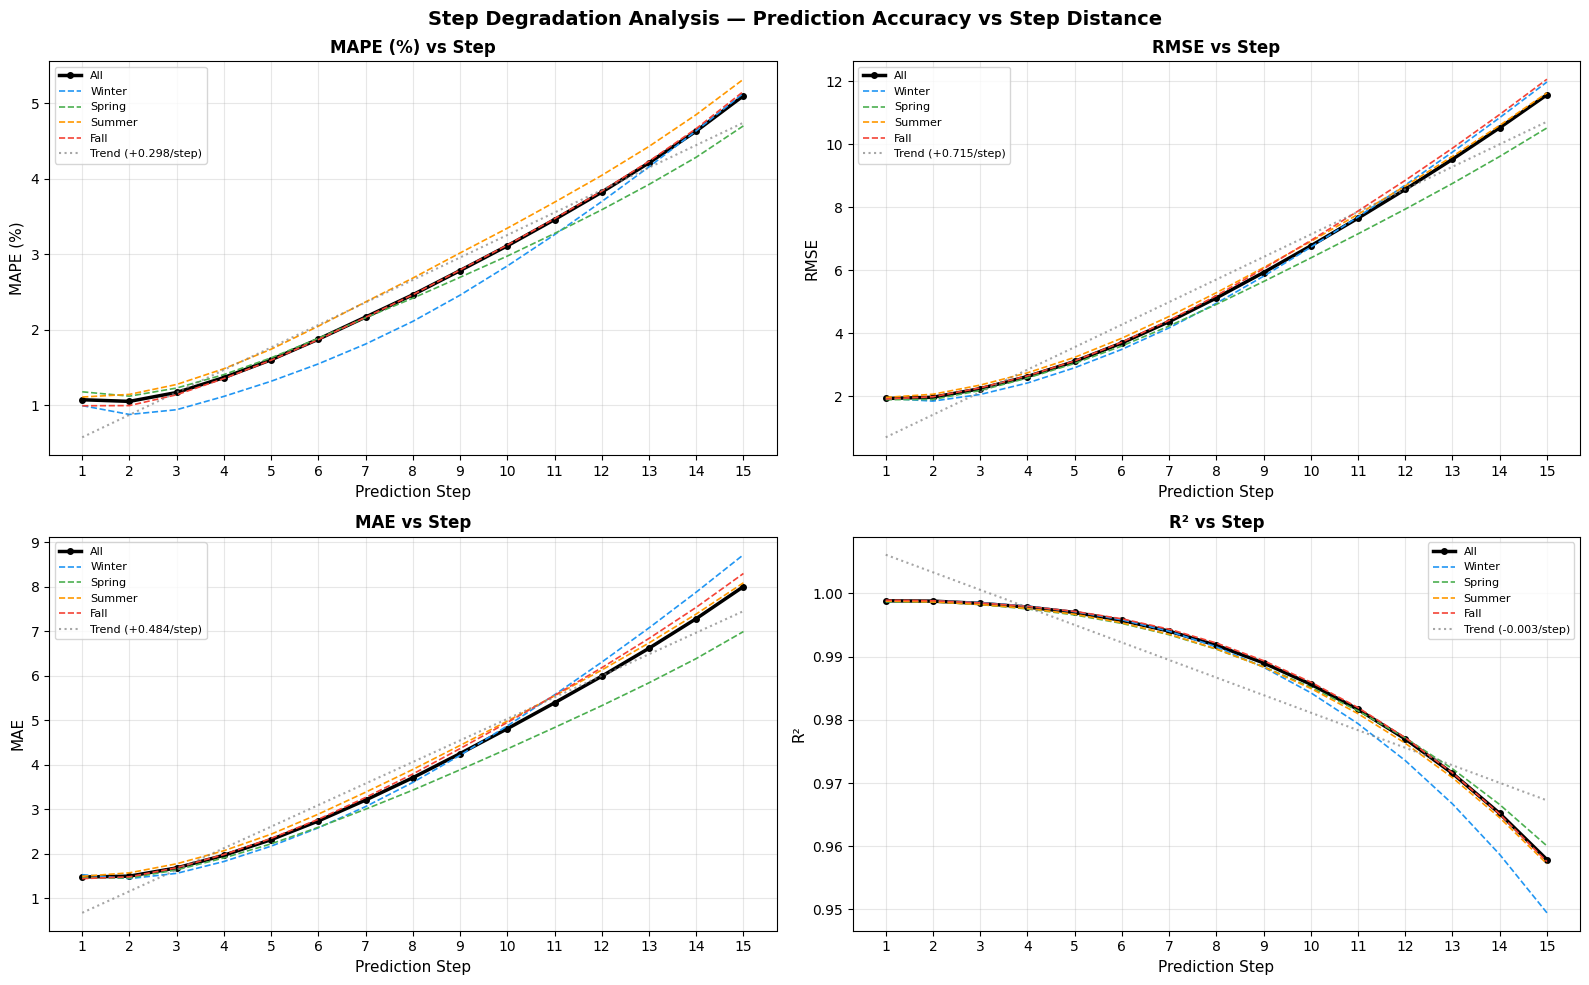


Step-weighted Loss 효과 분석
  Loss weight: Step 1 = 1.0, Step 15 = 2.0
  Step 1 MAPE: 1.07%
  Step 15 MAPE: 5.10%
  Ratio (Step15/Step1): 4.8x
  MAPE 증가율: 0.288%/step

  해석: Step 1(1분 후)에서 Step 15(15분 후)로 갈수록 MAPE가 4.8배 증가.


In [37]:
# Step 증가에 따른 예측 정확도 감소 추세 (전체 + 계절별)
from sklearn.metrics import r2_score as r2_fn

season_names = ['Winter', 'Spring', 'Summer', 'Fall']
block_sizes = [len(arr) for arr in X_test_list]
steps = np.arange(1, output_time + 1)

# 1) 전체 + 계절별 Step-wise 지표 계산
results = {}  # {name: {metric: [step1, ..., step15]}}

# 전체
all_metrics = {'MAPE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'Bias': []}
for s in range(output_time):
    a = test_actual_original[:, s]
    p = test_pred_original[:, s]
    mask = a != 0
    all_metrics['MAPE'].append(np.mean(np.abs((a[mask] - p[mask]) / a[mask])) * 100)
    all_metrics['RMSE'].append(np.sqrt(np.mean((a - p) ** 2)))
    all_metrics['MAE'].append(np.mean(np.abs(a - p)))
    all_metrics['R2'].append(r2_fn(a, p))
    all_metrics['Bias'].append(np.mean(a - p))
results['All'] = all_metrics

# 계절별
offset = 0
for name, size in zip(season_names, block_sizes):
    block_actual = test_actual_original[offset:offset + size]
    block_pred = test_pred_original[offset:offset + size]
    metrics = {'MAPE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'Bias': []}
    for s in range(output_time):
        a = block_actual[:, s]
        p = block_pred[:, s]
        mask = a != 0
        metrics['MAPE'].append(np.mean(np.abs((a[mask] - p[mask]) / a[mask])) * 100)
        metrics['RMSE'].append(np.sqrt(np.mean((a - p) ** 2)))
        metrics['MAE'].append(np.mean(np.abs(a - p)))
        metrics['R2'].append(r2_fn(a, p))
        metrics['Bias'].append(np.mean(a - p))
    results[name] = metrics
    offset += size

# 2) 선형 회귀로 감소율(기울기) 계산
from numpy.polynomial.polynomial import polyfit
print("=" * 70)
print("Step별 예측 감소 추세 — 선형 회귀 기울기 (step당 변화량)")
print("=" * 70)
print(f"\n{'':>10s}  {'MAPE':>12s}  {'RMSE':>12s}  {'MAE':>12s}  {'R2':>12s}  {'Bias':>12s}")
print("-" * 70)
for name in ['All'] + season_names:
    slopes = {}
    for metric in ['MAPE', 'RMSE', 'MAE', 'R2', 'Bias']:
        b, m = polyfit(steps, results[name][metric], 1)
        slopes[metric] = m
    print(f"{name:>10s}  {slopes['MAPE']:+.3f}%/step  "
          f"{slopes['RMSE']:+.3f}/step  {slopes['MAE']:+.3f}/step  "
          f"{slopes['R2']:+.5f}/step  {slopes['Bias']:+.3f}/step")

# Step 1 vs Step 15 비교
print(f"\n{'':>10s}  {'Step 1 MAPE':>12s}  {'Step 15 MAPE':>13s}  {'Ratio':>8s}  {'Step 1 R2':>10s}  {'Step 15 R2':>11s}")
print("-" * 70)
for name in ['All'] + season_names:
    m1 = results[name]['MAPE'][0]
    m15 = results[name]['MAPE'][-1]
    r1 = results[name]['R2'][0]
    r15 = results[name]['R2'][-1]
    print(f"{name:>10s}  {m1:10.2f}%  {m15:11.2f}%  {m15/m1:7.1f}x  {r1:10.4f}  {r15:11.4f}")

# 3) 시각화: 4개 지표 × (전체 + 계절별)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Step Degradation Analysis — Prediction Accuracy vs Step Distance',
             fontsize=14, fontweight='bold')

colors = {'All': 'black', 'Winter': '#2196F3', 'Spring': '#4CAF50',
          'Summer': '#FF9800', 'Fall': '#F44336'}
linewidths = {'All': 2.5, 'Winter': 1.2, 'Spring': 1.2, 'Summer': 1.2, 'Fall': 1.2}

for ax, metric, ylabel in zip(axes.flat,
    ['MAPE', 'RMSE', 'MAE', 'R2'],
    ['MAPE (%)', 'RMSE', 'MAE', 'R²']):

    for name in ['All'] + season_names:
        vals = results[name][metric]
        ax.plot(steps, vals, label=name, color=colors[name],
                linewidth=linewidths[name],
                linestyle='-' if name == 'All' else '--',
                marker='o' if name == 'All' else None,
                markersize=4)

    # 전체 추세선
    b, m = polyfit(steps, results['All'][metric], 1)
    trend = b + m * steps
    ax.plot(steps, trend, color='gray', linestyle=':', linewidth=1.5, alpha=0.7,
            label=f'Trend ({m:+.3f}/step)')

    ax.set_xlabel('Prediction Step', fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(f'{ylabel} vs Step', fontsize=12, fontweight='bold')
    ax.set_xticks(steps)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4) Step-weighted Loss 효과 분석
print("\n" + "=" * 70)
print("Step-weighted Loss 효과 분석")
print("=" * 70)
print(f"  Loss weight: Step 1 = 1.0, Step 15 = 2.0")
print(f"  Step 1 MAPE: {results['All']['MAPE'][0]:.2f}%")
print(f"  Step 15 MAPE: {results['All']['MAPE'][-1]:.2f}%")
print(f"  Ratio (Step15/Step1): {results['All']['MAPE'][-1]/results['All']['MAPE'][0]:.1f}x")
print(f"  MAPE 증가율: {(results['All']['MAPE'][-1]-results['All']['MAPE'][0])/(output_time-1):.3f}%/step")
print(f"\n  해석: Step 1(1분 후)에서 Step 15(15분 후)로 갈수록 MAPE가 "
      f"{results['All']['MAPE'][-1]/results['All']['MAPE'][0]:.1f}배 증가.")

/tmp/ipykernel_40249/1027609895.py:37: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_40249/1027609895.py:37: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/kp/web/work/pro/314env/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kp/web/work/pro/314env/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


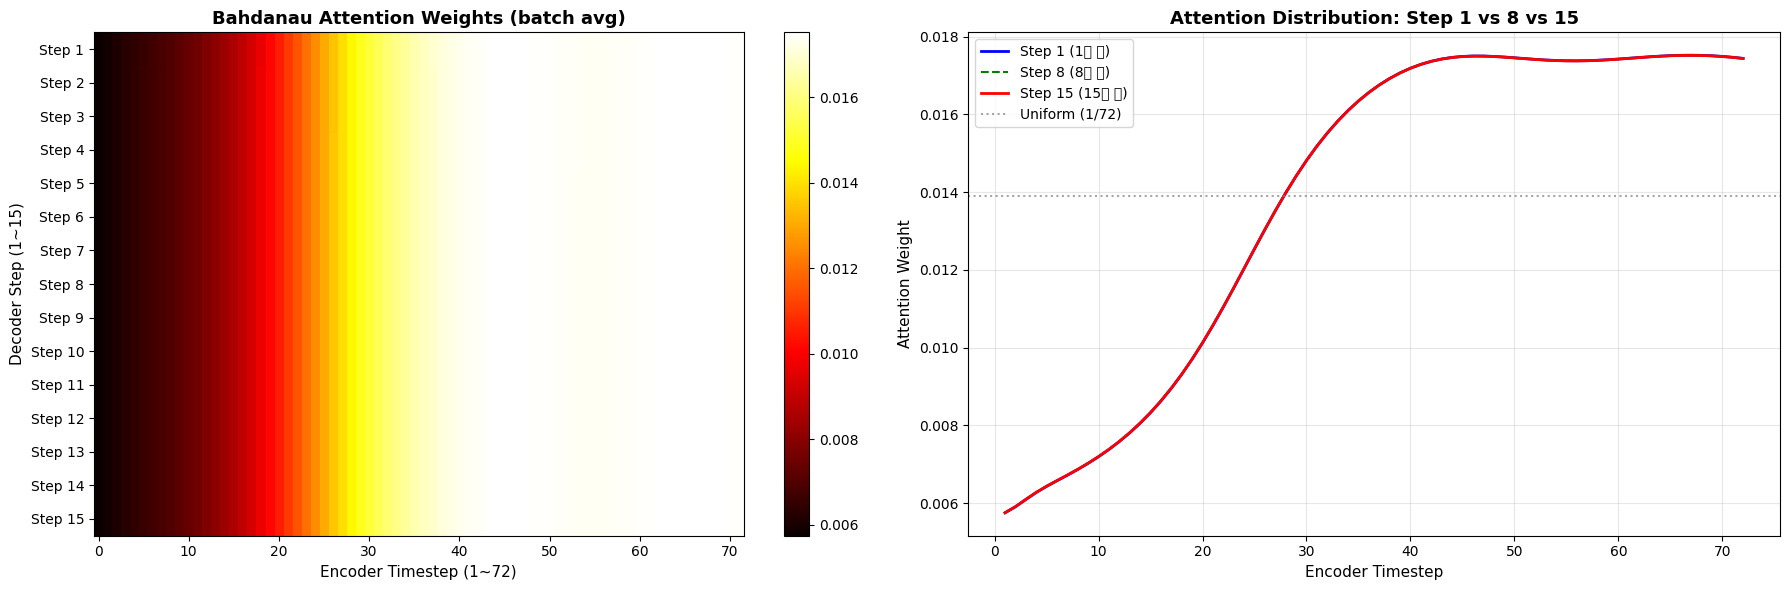

/tmp/ipykernel_40249/1027609895.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


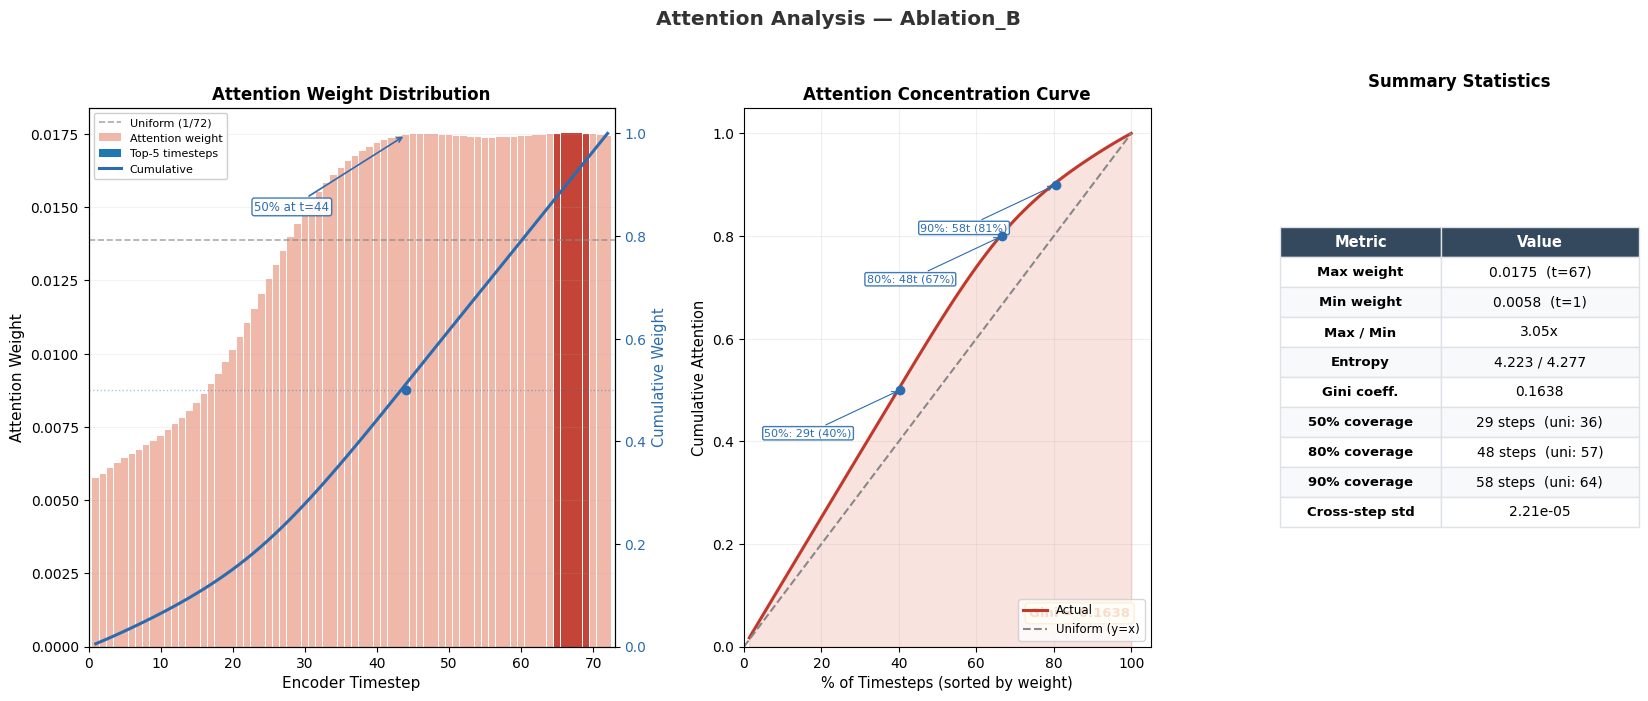


=== Attention 분석 요약 ===
Uniform weight: 0.0139
Entropy: 4.223 / 4.277 (actual / uniform)
Gini coefficient: 0.1638
Max/Min ratio: 3.05x
50% coverage: 29 / 72 timesteps
80% coverage: 48 / 72 timesteps
90% coverage: 58 / 72 timesteps
Cross-step entropy std: 2.21e-05
Top-5 attended timesteps: [67, 66, 68, 65, 69]


In [58]:
# Bahdanau Attention Heatmap + 분포 분석
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

model.eval()
with torch.no_grad():
    sample_X, _ = next(iter(test_loader))
    sample_X = sample_X.to(device)
    _ = model(sample_X)
    attn_weights = model.attn_weights_all  # (batch, 15, 72)

avg_attn = attn_weights.mean(dim=0).cpu().numpy()  # (15, 72)

# ════════════════════════════════════════════════════
# Figure 1: Heatmap + Step별 Attention 분포
# ════════════════════════════════════════════════════
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

im = axes[0].imshow(avg_attn, aspect='auto', cmap='hot', interpolation='nearest')
axes[0].set_xlabel('Encoder Timestep (1~72)', fontsize=11)
axes[0].set_ylabel('Decoder Step (1~15)', fontsize=11)
axes[0].set_title('Bahdanau Attention Weights (batch avg)', fontsize=13, fontweight='bold')
axes[0].set_yticks(range(output_time))
axes[0].set_yticklabels([f'Step {i+1}' for i in range(output_time)])
plt.colorbar(im, ax=axes[0])

axes[1].plot(range(1, input_time+1), avg_attn[0], label='Step 1 (1분 후)', linewidth=2, color='blue')
axes[1].plot(range(1, input_time+1), avg_attn[7], label='Step 8 (8분 후)', linewidth=1.5, color='green', linestyle='--')
axes[1].plot(range(1, input_time+1), avg_attn[-1], label='Step 15 (15분 후)', linewidth=2, color='red')
axes[1].axhline(y=1/input_time, color='gray', linestyle=':', label=f'Uniform (1/{input_time})', alpha=0.7)
axes[1].set_xlabel('Encoder Timestep', fontsize=11)
axes[1].set_ylabel('Attention Weight', fontsize=11)
axes[1].set_title('Attention Distribution: Step 1 vs 8 vs 15', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ════════════════════════════════════════════════════
# Figure 2: Weight Distribution + Concentration + Summary
# ════════════════════════════════════════════════════
attn_mean = avg_attn.mean(axis=0)  # (72,) — 전 step 평균
uniform_w = 1.0 / input_time
entropy_actual = -np.sum(attn_mean * np.log(attn_mean + 1e-10))
entropy_uniform = np.log(input_time)
cumulative = np.cumsum(attn_mean)
sorted_weights = np.sort(attn_mean)[::-1]
cum_sorted = np.cumsum(sorted_weights)
max_min_ratio = attn_mean.max() / attn_mean.min()
gini = np.sum(np.abs(np.subtract.outer(attn_mean, attn_mean))) / (2 * input_time**2 * attn_mean.mean())
n_for_50 = int(np.searchsorted(cum_sorted, 0.5) + 1)
n_for_80 = int(np.searchsorted(cum_sorted, 0.8) + 1)
n_for_90 = int(np.searchsorted(cum_sorted, 0.9) + 1)
step_entropies = [-np.sum(avg_attn[s] * np.log(avg_attn[s] + 1e-10)) for s in range(output_time)]
step_variance = np.std(step_entropies)
top5 = sorted(range(len(attn_mean)), key=lambda i: attn_mean[i], reverse=True)[:5]

timesteps = np.arange(1, input_time + 1)

fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 3, width_ratios=[1.1, 0.85, 0.75], wspace=0.3)

# ── PANEL 1: Attention Weight Distribution + Cumulative ──
ax1 = fig.add_subplot(gs[0])
ax1_twin = ax1.twinx()

ax1.bar(timesteps, attn_mean, color='#E8927C', alpha=0.65, width=0.9, label='Attention weight')
for idx in top5:
    ax1.bar(idx + 1, attn_mean[idx], color='#C0392B', alpha=0.9, width=0.9)
ax1.bar([], [], color='#C0392B', alpha=0.9, label='Top-5 timesteps')
ax1.axhline(y=uniform_w, color='#888', linestyle='--', linewidth=1.2,
            label=f'Uniform (1/{input_time})', alpha=0.7)

ax1_twin.plot(timesteps, cumulative, color='#2B6CB0', linewidth=2.2, label='Cumulative')
ax1_twin.set_ylabel('Cumulative Weight', fontsize=10.5, color='#2B6CB0')
ax1_twin.tick_params(axis='y', labelcolor='#2B6CB0')
ax1_twin.set_ylim(0, 1.05)

idx_50 = np.searchsorted(cumulative, 0.5)
ax1_twin.axhline(y=0.5, color='#2B6CB0', linestyle=':', linewidth=1, alpha=0.4)
ax1_twin.plot(idx_50 + 1, 0.5, 'o', color='#2B6CB0', markersize=6, zorder=5)
ax1.annotate(f'50% at t={idx_50 + 1}',
             xy=(idx_50 + 1, attn_mean[idx_50]),
             xytext=(idx_50 - 20, attn_mean.max() * 0.85),
             fontsize=8.5, color='#2B6CB0',
             arrowprops=dict(arrowstyle='->', color='#2B6CB0', lw=1.2),
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='#2B6CB0', alpha=0.9))

ax1.set_xlabel('Encoder Timestep', fontsize=11)
ax1.set_ylabel('Attention Weight', fontsize=11)
ax1.set_title('Attention Weight Distribution', fontsize=12, fontweight='bold')
ax1.set_xlim(0, input_time + 1)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8, framealpha=0.95)
ax1.grid(axis='y', alpha=0.15)

# ── PANEL 2: Attention Concentration Curve (Lorenz-style) ──
ax2 = fig.add_subplot(gs[1])
pct_timesteps = np.arange(1, input_time + 1) / input_time * 100

ax2.fill_between(pct_timesteps, cum_sorted, alpha=0.25, color='#E8927C')
ax2.plot(pct_timesteps, cum_sorted, color='#C0392B', linewidth=2.2, label='Actual')
ax2.plot([0, 100], [0, 1], color='#888', linestyle='--', linewidth=1.5, label='Uniform (y=x)')

for threshold in [0.5, 0.8, 0.9]:
    n_needed = np.searchsorted(cum_sorted, threshold) + 1
    pct_needed = n_needed / input_time * 100
    ax2.plot(pct_needed, threshold, 'o', color='#2B6CB0', markersize=6, zorder=5)
    ax2.annotate(f'{threshold*100:.0f}%: {n_needed}t ({pct_needed:.0f}%)',
                 xy=(pct_needed, threshold),
                 xytext=(pct_needed - 35, threshold - 0.09),
                 fontsize=8, color='#2B6CB0',
                 arrowprops=dict(arrowstyle='->', color='#2B6CB0', lw=0.8),
                 bbox=dict(boxstyle='round,pad=0.15', facecolor='white',
                           edgecolor='#2B6CB0', alpha=0.9))

ax2.text(0.95, 0.05, f'Gini = {gini:.4f}',
         transform=ax2.transAxes, fontsize=9.5, ha='right', va='bottom',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFF8E1', edgecolor='#F9A825', alpha=0.95),
         fontweight='bold', color='#E65100')

ax2.set_xlabel('% of Timesteps (sorted by weight)', fontsize=10.5)
ax2.set_ylabel('Cumulative Attention', fontsize=10.5)
ax2.set_title('Attention Concentration Curve', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8.5, loc='lower right')
ax2.set_xlim(0, 105)
ax2.set_ylim(0, 1.05)
ax2.grid(True, alpha=0.2)

# ── PANEL 3: Summary Statistics Table ──
ax3 = fig.add_subplot(gs[2])
ax3.axis('off')

table_data = [
    ['Metric', 'Value'],
    ['Max weight', f'{attn_mean.max():.4f}  (t={attn_mean.argmax()+1})'],
    ['Min weight', f'{attn_mean.min():.4f}  (t={attn_mean.argmin()+1})'],
    ['Max / Min', f'{max_min_ratio:.2f}x'],
    ['Entropy', f'{entropy_actual:.3f} / {entropy_uniform:.3f}'],
    ['Gini coeff.', f'{gini:.4f}'],
    ['50% coverage', f'{n_for_50} steps  (uni: {input_time//2})'],
    ['80% coverage', f'{n_for_80} steps  (uni: {int(input_time*0.8)})'],
    ['90% coverage', f'{n_for_90} steps  (uni: {int(input_time*0.9)})'],
    ['Cross-step std', f'{step_variance:.2e}'],
]

table = ax3.table(
    cellText=table_data[1:],
    colLabels=table_data[0],
    loc='center',
    cellLoc='center',
    colWidths=[0.45, 0.55]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.8)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor('#34495E')
        cell.set_text_props(color='white', fontweight='bold', fontsize=10.5)
    else:
        cell.set_facecolor('#F8F9FA' if row % 2 == 0 else 'white')
        if col == 0:
            cell.set_text_props(fontweight='bold', fontsize=9.5)
    cell.set_edgecolor('#DEE2E6')

ax3.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=15)
fig.suptitle(f'Attention Analysis — {model_name}', fontsize=14.5, fontweight='bold', y=1.02, color='#333')
plt.tight_layout()
plt.show()

# ── 정량 분석 출력 ──
print("\n=== Attention 분석 요약 ===")
print(f"Uniform weight: {uniform_w:.4f}")
print(f"Entropy: {entropy_actual:.3f} / {entropy_uniform:.3f} (actual / uniform)")
print(f"Gini coefficient: {gini:.4f}")
print(f"Max/Min ratio: {max_min_ratio:.2f}x")
print(f"50% coverage: {n_for_50} / {input_time} timesteps")
print(f"80% coverage: {n_for_80} / {input_time} timesteps")
print(f"90% coverage: {n_for_90} / {input_time} timesteps")
print(f"Cross-step entropy std: {step_variance:.2e}")
print(f"Top-5 attended timesteps: {[i+1 for i in top5]}")

### Attention 분석 결과 해석

#### Figure 1: Heatmap + Step별 Attention 분포

| 요소 | 의미 |
|------|------|
| **Heatmap (좌)** | X축: Encoder Timestep (1~72), Y축: Decoder Step (1~15). 밝을수록(노란색) 강하게 참조 |
| **Line Plot (우)** | Step 1/8/15의 attention 분포 비교. 회색 점선 = Uniform 기준선 (1/72) |

#### Figure 2: Attention 분포 정량 분석

- **Panel 1 — Weight Distribution + Cumulative:** 각 encoder timestep별 attention weight를 바 차트로, 누적합을 오버레이로 표시합니다. Top-5 timestep은 진한 빨간색으로 강조되고, 50% 도달 지점이 annotation으로 표시됩니다.
- **Panel 2 — Concentration Curve:** Lorenz curve 방식으로 attention 집중도를 분석합니다. y=x 대각선(uniform)과 비교하여, 전체 attention의 50%/80%/90%를 커버하는 데 필요한 timestep 수를 보여줍니다. Gini coefficient로 불균등도를 정량화합니다.
- **Panel 3 — Summary Statistics:** 주요 지표를 테이블로 정리합니다. Cross-step σ는 decoder step 간 entropy 표준편차로, 이 값으로 step별 attention 변화 정도를 확인할 수 있습니다.

#### 주요 지표 설명

| 지표 | 의미 |
|------|------|
| **Max/Min weight** | 가장 강하게/약하게 참조되는 timestep의 가중치 |
| **Max/Min ratio** | 최대·최소 가중치 비율 — 클수록 차별화 강함 |
| **Entropy** | 분포 균일도. Uniform entropy에 가까울수록 균등 분포 |
| **Gini coefficient** | 0=완전 균등, 1=완전 집중. 불균등 정도의 단일 지표 |
| **Coverage (50/80/90%)** | 누적 가중치가 해당 비율에 도달하는 데 필요한 timestep 수. Uniform 대비 적을수록 집중도 높음 |
| **Cross-step std** | Step 간 entropy 표준편차 — 낮을수록 step별 attention 패턴이 유사 |

In [59]:
# Best run 모델 저장 (Ablation B용 파일명)
model_path = BASE_DIR / "models" / "ablation_b_dropout_removed.pth"

torch.save({
    'model_name': model_name,
    'model_state_dict': model.state_dict(),
    'scalers': {col: {'min': scalers[col].data_min_[0], 'max': scalers[col].data_max_[0]} for col in scale_cols},
    'feature_cols': feature_cols,
    'scale_cols': scale_cols,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_loss': best_run['mape'],
    'best_epoch': len(train_losses),
    'best_seed': best_run['seed'],
    'input_time': input_time,
    'output_time': output_time,
}, model_path)

print(f"모델 저장 완료: {model_path}")

모델 저장 완료: /home/kp/web/work/pro/models/ablation_b_dropout_removed.pth
